In [1]:
# prerequisites
!pip install fredapi

In [2]:
# libraries
import yfinance as yf
import pandas as pd
from fredapi import Fred
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import MonthEnd
import torch.autograd as autograd
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
# fred api key
FRED_API_KEY = '6f6c7b260a6a1a0931ab29ca5ac3ddb1'
fred = Fred(api_key=FRED_API_KEY)

In [4]:
# Suppress all warnings
warnings.filterwarnings("ignore")

### Function Definitions

In [5]:
# extracting data
def flattenAndAddTicker(data,ticker):
  data.columns = data.columns.get_level_values(0)
  ticker_label = '_' + ticker
  new_cols = []
  for col in data.columns:
    col += ticker_label
    new_cols.append(col)
  data.columns = new_cols
  return data

def get_expiration_date(date):
      # third last business day of the month
      exp_date = pd.Timestamp(date.year, date.month, 1) + MonthEnd(3)
      return exp_date

def getData(spotTckr, futuresTckr, start, end):
  dfs = []
  # yahoo finance data
  tckrs = [futuresTckr,spotTckr]
  for t in tckrs:
    d = yf.download(t,start=start, end=end)
    d = flattenAndAddTicker(d,t)
    dfs.append(d)
  spotPrice = 'Close_'+spotTckr
  futuresPrice = 'Close_'+futuresTckr

  # fred data
  # risk free rate
  rfr = fred.get_series('DGS3MO', start=start, end=end) / 100.0   # 3 month treasury rate
  macro_data = pd.concat([rfr], axis=1)
  macro_data.columns = ['Risk_Free_Rate']
  macro_data = macro_data.reindex(dfs[0].index).ffill().dropna()
  dfs.append(macro_data)

  # combine the data
  data = pd.concat(dfs, axis=1).dropna()

  # calculations
  # mu_s - drift of spot price
  data['log_return'] = np.log(data[spotPrice] / data[spotPrice].shift(1))
  data['mu_s'] = data['log_return'].rolling(window=252).mean() * 252
  # using log returns to ensure normality, variance stability, and symmetry

  # sigma - volatility
  data['sigma'] = data['log_return'].rolling(window=252).std() * np.sqrt(252)

  # gamma - long-run variance
  data['variance'] = data['log_return'].rolling(window=252).var() * 252
  data['gamma'] = data['variance'].rolling(window=252*3).mean()  # 3-year window

  # kappa - rate of mean rev
  v_series = data['variance'].dropna()
  model = AutoReg(v_series, lags=1, old_names=False).fit()
  data['kappa'] = model.params.iloc[1]

  # rho - correlation between stock price and variance
  data['variance_diff'] = data['variance'].diff()
  data['rho'] = data['log_return'].rolling(window=252).corr(data['variance_diff'])

  # mu_v - drift of volatility
  data['mu_v'] = data['kappa'] * (data['gamma'] - data['variance'])

  # time to maturity - assumes monthly expiration
  data['expiration_date'] = data.index.to_series().apply(get_expiration_date)
  data['T_t'] = (data['expiration_date'] - data.index).dt.days / 365.0

  data = data.dropna()
  return data

In [6]:
# extract input and target tensors
def extractTensors(data, spotTckr, futuresTckr):
  spotPrice = 'Close_'+spotTckr
  futuresPrice = 'Close_'+futuresTckr
  # input features
  spot_price = data[spotPrice].values
  rfr = data['Risk_Free_Rate'].values
  T_t = data['T_t'].values
  mu_s = data['mu_s'].values
  mu_v = data['mu_v'].values
  kappa = data['kappa'].values
  gamma = data['gamma'].values
  sigma = data['sigma'].values
  rho = data['rho'].values
  V_t = data['variance'].values
  # target feature
  futures_price = data[futuresPrice].values

  # vertically stack input arrays
  X = np.vstack([spot_price, rfr, T_t, mu_s, kappa, gamma, sigma, rho, mu_v, V_t]).T
  # order requirements
  # - X[:, 0] is spot price S.
  # - X[:, 1] is risk-free rate r.
  # - X[:, 6] is volatility σ.

  # normalize features to ensure values are from 0-1
  scaler_X = MinMaxScaler()
  X_scaled = scaler_X.fit_transform(X)

  scaler_y = MinMaxScaler()
  y_scaled = scaler_y.fit_transform(futures_price.reshape(-1, 1))

  # convert np arrays to pytorch tensors, ensuring gradient computation is possible
  X_tensor = torch.tensor(X_scaled, dtype=torch.float32, requires_grad=True)
  y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

  return X_tensor, y_tensor, scaler_y

In [7]:
# define the PINN class
# PINN is a subclass of nn.Module, the base class for all pytorch models
class PINN(nn.Module):
  def __init__(self, input_dim):
    # multi-layer perceptron (feedforward)
    super(PINN, self).__init__()
    self.layer1 = nn.Linear(input_dim, 64)
    # increase width
    self.layer2 = nn.Linear(64, 128)
    self.layer3 = nn.Linear(128, 128)
    self.layer4 = nn.Linear(128, 64)
    # produce output (futures price)
    self.out_layer = nn.Linear(64, 1)

  def forward(self, x):
    # tanh as the nonlinear activation function
    x1 = torch.tanh(self.layer1(x))
    x2 = torch.tanh(self.layer2(x1))
    x3 = torch.tanh(self.layer3(x2))
    # skip connection
    x4 = torch.tanh(self.layer4(x3) + x1)
    out = self.out_layer(x4)
    return out

In [8]:
# physics informed loss function
def physics_informed_loss(y_true, y_pred, X, lambda_phys=0.3):
  # unpack inputs exactly as before…
  S_t   = X[:, 0].view(-1, 1)
  r     = X[:, 1].view(-1, 1)
  r = X[:, 1].view(-1, 1)           # risk free rate
  T_t = X[:, 2].view(-1, 1)         # time to maturity (T - t)
  mu_s = X[:, 3].view(-1, 1)        # drift for spot price
  kappa = X[:, 4].view(-1, 1)       # rate of mean reversion for volatility
  gamma = X[:, 5].view(-1, 1)       # long-run variance
  sigma = X[:, 6].view(-1, 1)       # volatility
  rho = X[:, 7].view(-1, 1)         # correlation between S_t and V_t
  mu_v = X[:, 8].view(-1, 1)        # variance drift
  V_t   = X[:, 9].view(-1, 1)
  V     = y_pred

  # 1) first derivatives ∇_X V
  grad_V = autograd.grad(
      V, X,
      grad_outputs=torch.ones_like(V),
      create_graph=True
  )[0]
  dV_dS  = grad_V[:, 0].view(-1, 1)
  dV_dVt = grad_V[:, 9].view(-1, 1)
  dV_dt  = grad_V[:, 2].view(-1, 1)

  # 2) second derivatives by differentiating those grads w.r.t. X again:
  #    note we always differentiate wrt X, then select the appropriate column
  grad2 = autograd.grad(
      dV_dS, X,
      grad_outputs=torch.ones_like(dV_dS),
      create_graph=True
  )[0]
  d2V_dS2  = grad2[:, 0].view(-1, 1)    # ∂²V/∂S²
  d2V_dSdV = grad2[:, 9].view(-1, 1)    # ∂²V/∂S∂V_t

  grad2_v = autograd.grad(
      dV_dVt, X,
      grad_outputs=torch.ones_like(dV_dVt),
      create_graph=True
  )[0]
  d2V_dV2 = grad2_v[:, 9].view(-1, 1)   # ∂²V/∂V_t²

  # 3) assemble the trace term for a Heston‐style diffusion:
  trace_term = 0.5 * (
      S_t**2 * V_t * d2V_dS2
    + 2 * rho * sigma * S_t * V_t * d2V_dSdV
    + sigma**2 * V_t * d2V_dV2
  )

  # 4) drift and time‐derivative
  drift_term = mu_s * dV_dS + mu_v * dV_dVt

  # 5) PDE residual
  pde_residual = dV_dt - r * V + drift_term + trace_term

  # 6) losses
  physics_loss = torch.mean(pde_residual**2)
  mse_loss     = nn.MSELoss()(V, y_true)
  total_loss   = mse_loss + lambda_phys * physics_loss

  return physics_loss, mse_loss, total_loss


In [9]:
# model training using train-test split for validation
def train(model, X_tensor, y_tensor, scaler_y, futuresPrice, epochs=100, lambda_phys=0.3, test_size=0.2, random_state=42, showTraining = True):
    # Convert PyTorch tensors to numpy arrays for splitting (if needed)
    X_np = X_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()

    # Split data into training and validation sets
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_np, y_np, test_size=test_size, random_state=random_state)

    # Convert back to torch tensors (make sure gradients are enabled for train split)
    X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
    y_train = torch.tensor(y_train_np, dtype=torch.float32)

    X_val = torch.tensor(X_val_np, dtype=torch.float32, requires_grad=True)
    y_val = torch.tensor(y_val_np, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        optimizer.zero_grad()

        # Forward pass on training data
        y_pred_train = model(X_train)

        # Compute physics-informed loss on training set
        physics_loss, mse_loss, total_loss = physics_informed_loss(y_train, y_pred_train, X_train, lambda_phys)

        total_loss.backward()
        optimizer.step()

        if showTraining == True and (epoch + 1) % 10 == 0:
            # Display training losses every 10 epochs
            print(f'Epoch {epoch+1}/{epochs}',
                  f'\nTrain Physics Loss: {physics_loss.item():.4f}',
                  f', Train MSE Loss: {mse_loss.item():.4f}',
                  f', Train Total Loss: {total_loss.item():.4f}', sep='')

    # --- Final Evaluation on Test Data (After Training Completes) ---
    model.eval()
    # We need gradients for physics loss, so do not wrap in torch.no_grad()
    with torch.enable_grad():
        y_pred_test = model(X_val)
        # Ensure X_val still has requires_grad (it should already)
        physics_loss_test, mse_loss_test, total_loss_test = physics_informed_loss(y_val, y_pred_test, X_val, lambda_phys)

    # Now that we have computed the test losses, we can disable gradients for prediction scaling:
    with torch.no_grad():
        preds_scaled_test = y_pred_test.detach().cpu().numpy()
        predictions_test = scaler_y.inverse_transform(preds_scaled_test)

    # print('------------------------------------------------------------------------------')
    print('-'*100)
    print(f'Final Test Physics Loss: {physics_loss_test.item():.4f}')
    print(f'Final Test MSE Loss: {mse_loss_test.item():.4f}')
    print(f'Final Test Total Loss: {total_loss_test.item():.4f}')


    # Return model and predictions (or any other evaluation metrics)
    # return model, predictions_test


In [10]:
# test PINN across different assets
def test_PINN(spotTckr, futuresTckr, showTraining = False, showVis = False, epochs=250, start = '2010-06-07', end = '2025-04-01'):
  # get data
  data = getData(spotTckr, futuresTckr, start, end)
  futuresPrice = data['Close_'+futuresTckr].values
  # extract tensors
  X_tensor, y_tensor, scaler_y = extractTensors(data, spotTckr, futuresTckr)
  input_dim = X_tensor.shape[1]
  # initialize and train the model
  model = PINN(input_dim)
  train(model, X_tensor, y_tensor, scaler_y, futuresPrice, epochs=epochs, lambda_phys=0.3, showTraining=showTraining)
  # generate PINN prices
  V = model(X_tensor).detach().cpu().numpy()
  V = scaler_y.inverse_transform(V).flatten()           # PINN prices
  data['PINN_Price'] = V
  if showVis:
    visualizePrices(spotTckr,futuresTckr,data)
  return data

In [11]:
# visualize broker prices against PINN prices
def visualizePrices(spotTckr,futuresTckr,data):
  # visualization - payoff from PINN vs yfinance prices
  S_t = data['Close_'+spotTckr].values        # spot
  K = data['Close_'+futuresTckr].values       # actual futures price
  V = data['PINN_Price'].values               # PINN price
  dates = data.index.values

  plt.plot(dates, S_t, label=f'Spot Price from {spotTckr}')
  plt.plot(dates, K, label=f'Futures Price from {futuresTckr}')
  plt.plot(dates, V, label='PINN Price')
  plt.legend()
  plt.title('Broker and PINN Asset Prices')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  plt.show()

In [12]:
# plot ticker prices and correlations to identify which futures-spot pair to use
def choosingSpot(start,end,tickers):
  dfs = []
  for ticker in tickers:
    # get data
    df = yf.download(ticker,start=start,end=end)
    dfs.append(df)
  # plot ticker prices
  for i in range(len(tickers)):
    plt.plot(dfs[i]['Close'], label=tickers[i])
  plt.legend()
  plt.title('Ticker Prices')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  plt.show()
  print()
  # plot correlations
  cols = []
  for df in dfs:
    col = df.columns.get_level_values(0)
    cols.append(col)
  close_df = pd.DataFrame(dfs[0]['Close'].values, columns=[tickers[0]],index=dfs[0].index)
  for i in range(1,len(tickers)):
    close_df[tickers[i]] = dfs[i]['Close']
  returns_df = close_df.pct_change().dropna()
  correlation = returns_df.corr()
  sns.heatmap(correlation, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix of Daily Returns')
  plt.show()


In [13]:
# extracting spread signals
def getDropSignalsDf(data,spotTckr,futuresTckr,sd,t):
  df = data.copy()
  fut_col = f'Close_{futuresTckr}'

  # spread between PINN price and futures price
  spread = data[fut_col] - data['PINN_Price']
  mu, sigma = spread.mean(), spread.std()

  # if the spread is greater than k std, the signal is 1; otherwise it is 0
  data['Signal'] = (spread > mu + sd * sigma).astype(int)

  # return from h days ahead
  data['Future_Return'] = data[fut_col].shift(-t) / data[fut_col] - 1

  # drop rows with NaNs in signal or return
  df = data.dropna(subset=['Signal', 'Future_Return'])

  # extract relevant columns
  df = df.loc[:,['Close_'+spotTckr, 'Close_'+futuresTckr, 'PINN_Price', 'Signal', 'Future_Return']]

  return df

In [14]:
# visualization with signals
def visDropSignals(spotTckr,futuresTckr,data):
  S_t = data['Close_' + spotTckr].values
  K = data['Close_' + futuresTckr].values
  V = data['PINN_Price'].values
  dates = data.index

  plt.plot(dates, S_t, label=f'Spot Price from {spotTckr}')
  plt.plot(dates, K, label=f'Futures Price from {futuresTckr}')
  plt.plot(dates, V, label='PINN Price')

  # highlight regions where Signal == 1
  in_signal = False
  start_date = None

  for i in range(len(data)):
    if data['Signal'].iloc[i] == 1 and not in_signal:
      start_date = dates[i]
      in_signal = True
    elif data['Signal'].iloc[i] == 0 and in_signal:
      end_date = dates[i]
      plt.axvspan(start_date, end_date, color='yellow', alpha=0.2)
      in_signal = False

  plt.legend()
  plt.title('Prices with Signal Regions Highlighted')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  plt.show()

In [15]:
# t-test to see if signal produces significant results
def analyzeCausation(df,futuresTckr):
    fut_col = f'Close_{futuresTckr}'
    # two‐sample t‑test
    # testing whether the average future return is significantly
    #   different after a signal compared to when there is no signal
    # mu = mean return
    # H_0: mu_signal = mu_no_signal vs H_A: mu_signal != mu_no_signal
    signal   = df.loc[df['Signal'] == 1, 'Future_Return']
    noSignal = df.loc[df['Signal'] == 0, 'Future_Return']
    tstat, pval = ttest_ind(signal, noSignal, equal_var=False)
    print(f"\nT‑test (return after signal vs no signal):")
    print(f"  t‑stat = {tstat:.4f}, p‑value = {pval:.8f}")

### Choosing the Best Spot and Futures Tickers

In [16]:
start = '2010-06-07'
end = '2025-04-01'

#### Fixed Income

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


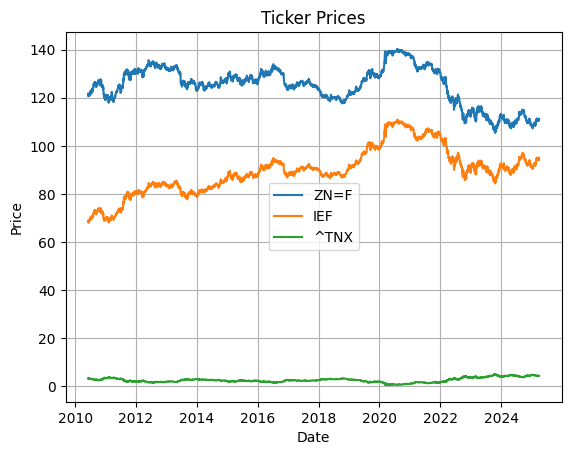

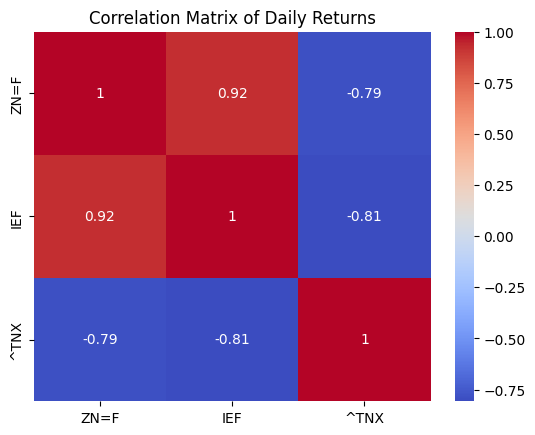

In [17]:
# 10-Year T-note Futures
tickers = ['ZN=F', 'IEF', '^TNX']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


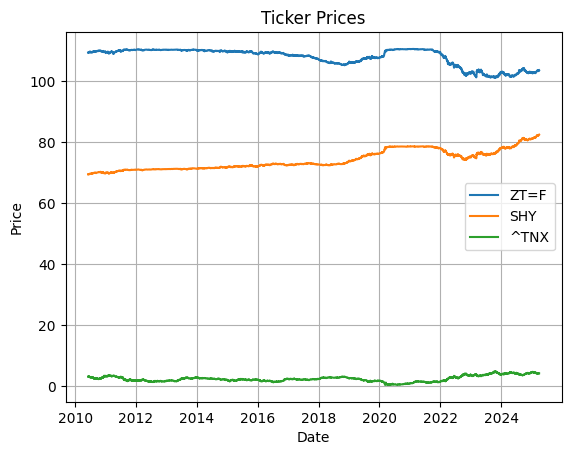

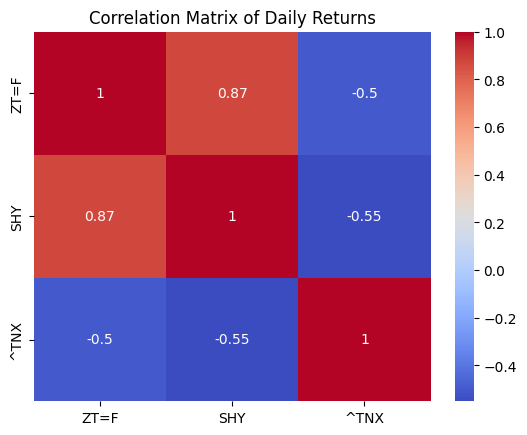

In [18]:
# 2-Year T-Note Futures
tickers = ['ZT=F', 'SHY', '^TNX']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


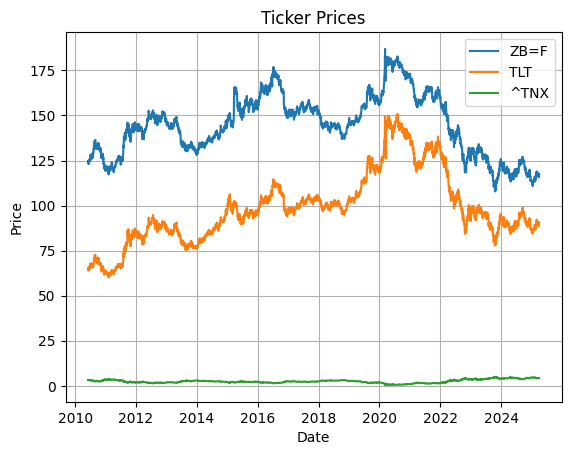

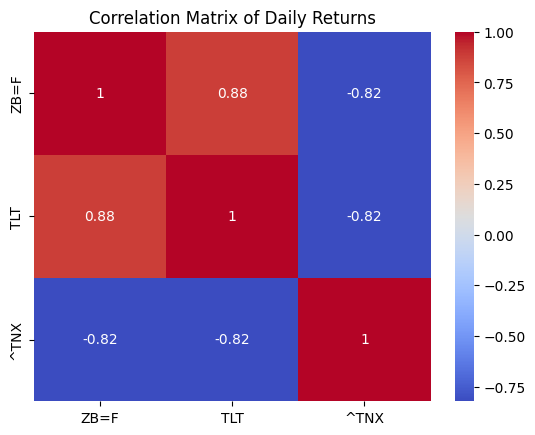

In [19]:
# 30-Year T-Bond
tickers = ['ZB=F', 'TLT', '^TNX']
choosingSpot(start,end,tickers)

#### Commodities

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


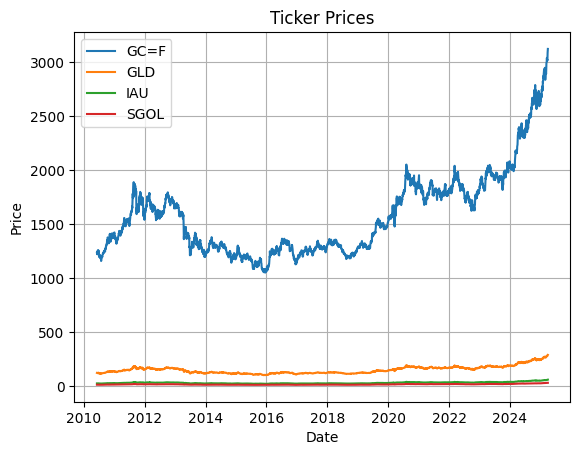

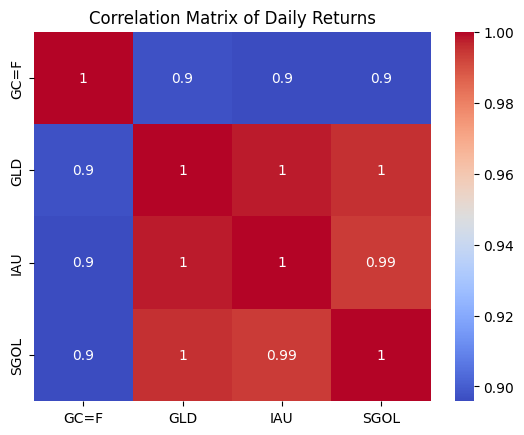

In [20]:
# Gold
tickers = ['GC=F', 'GLD', 'IAU', 'SGOL']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


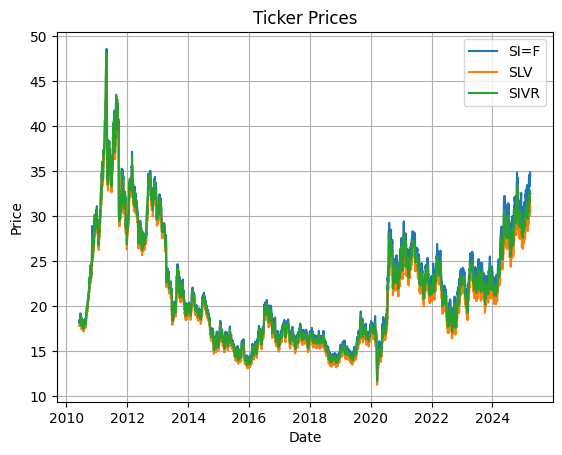

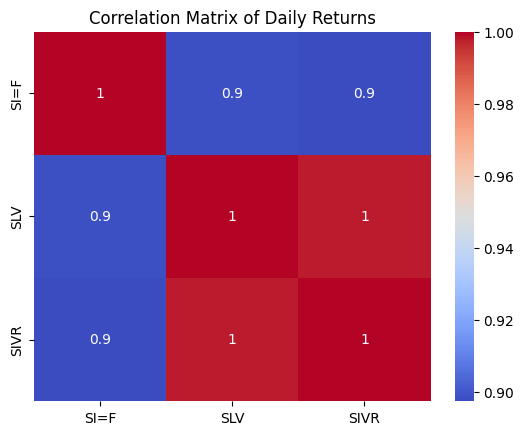

In [21]:
# Silver
tickers = ['SI=F', 'SLV','SIVR']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


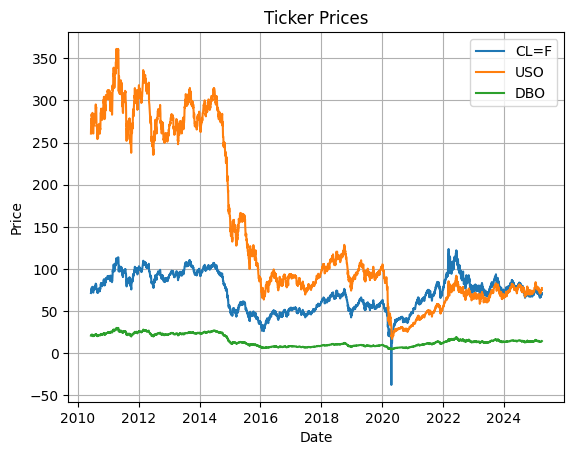

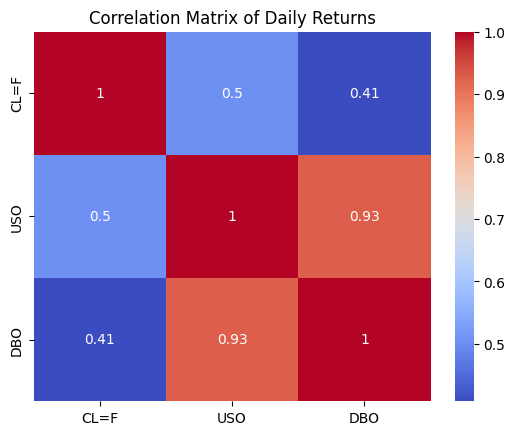

In [22]:
# Crude Oil
tickers = ['CL=F', 'USO', 'DBO']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


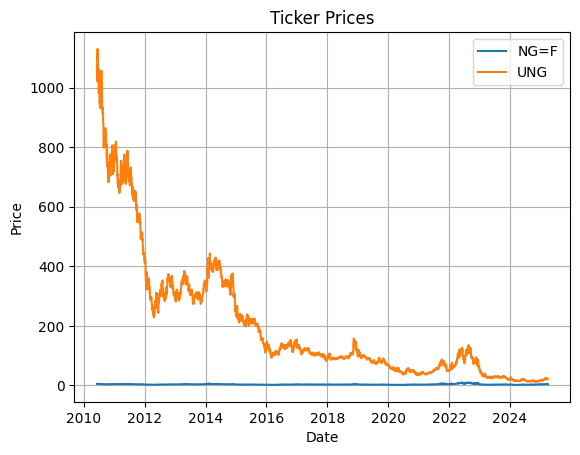

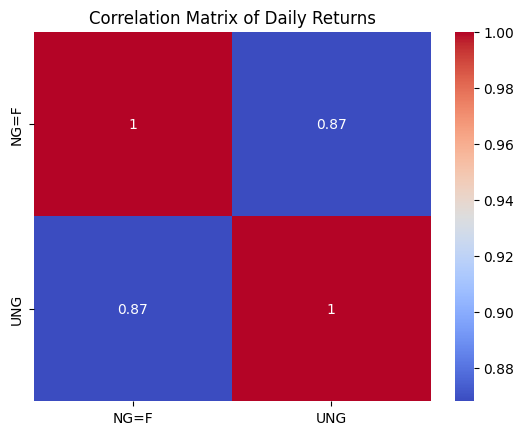

In [23]:
# Natural Gas
tickers = ['NG=F', 'UNG']
choosingSpot(start,end,tickers)

#### Equities

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


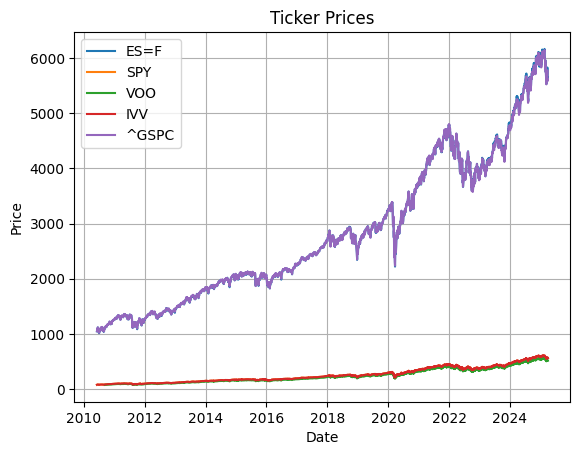

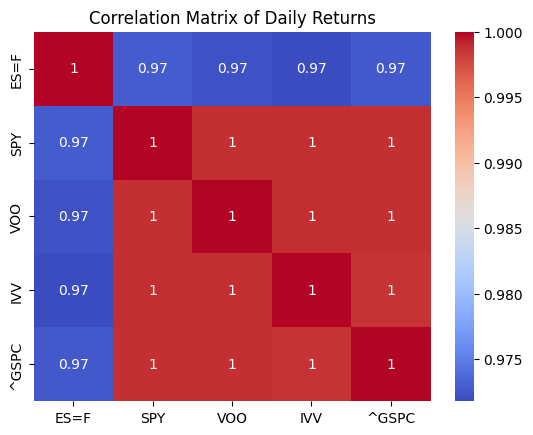

In [24]:
# S&P 500
tickers = ['ES=F', 'SPY', 'VOO', 'IVV', '^GSPC']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


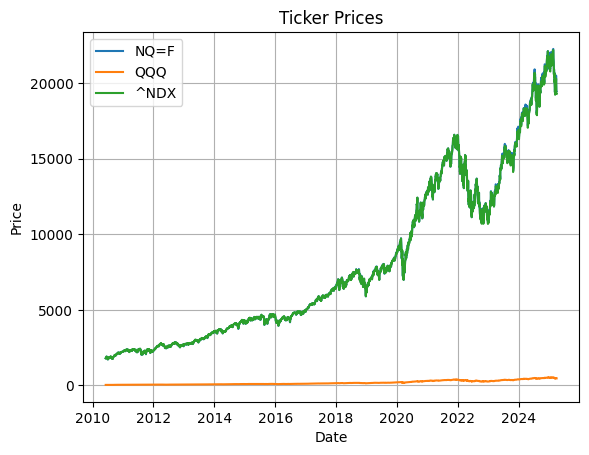

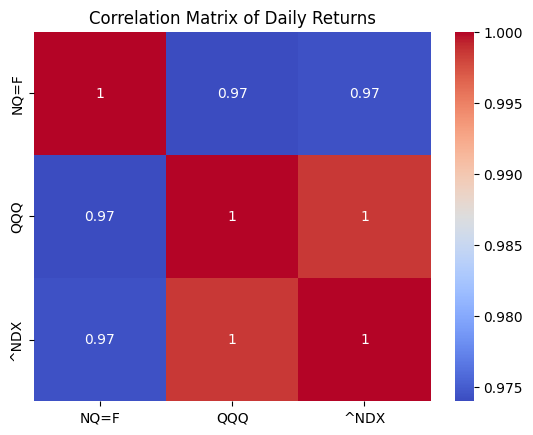

In [25]:
# Nasdaq 100
tickers = ['NQ=F', 'QQQ', '^NDX']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


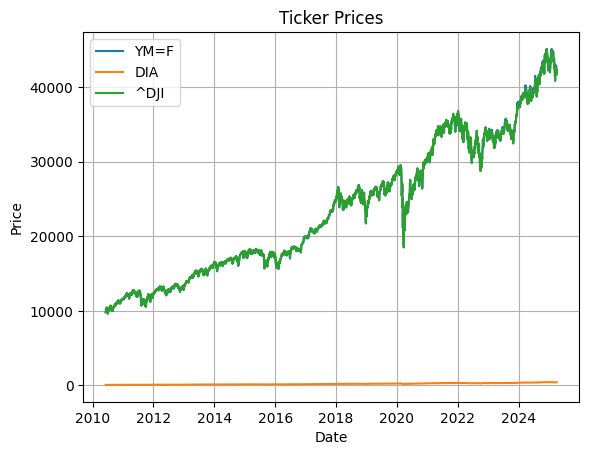

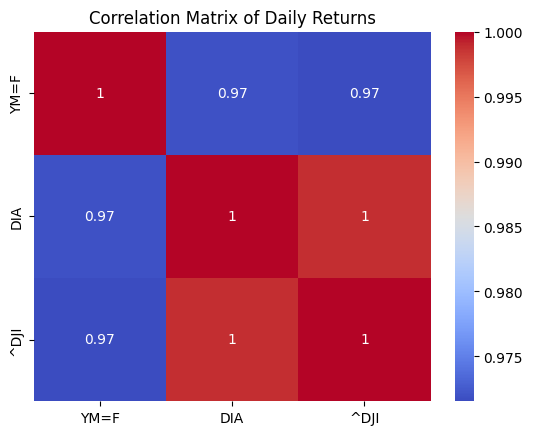

In [26]:
# Equities - Dow Jones
tickers = ['YM=F', 'DIA', '^DJI']
choosingSpot(start,end,tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


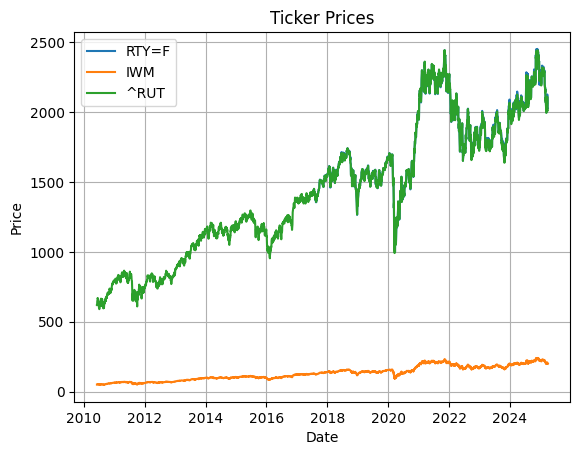

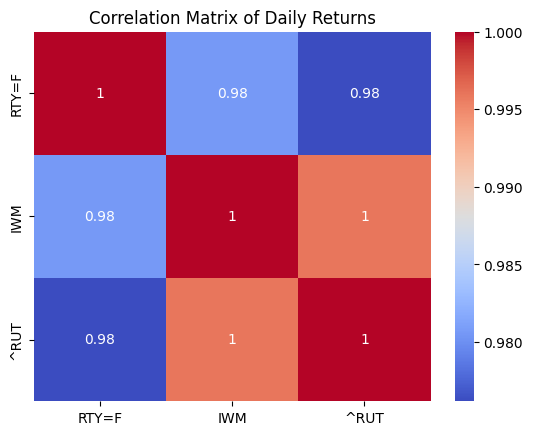

In [27]:
# Russell 2000
tickers = ['RTY=F', 'IWM', '^RUT']
choosingSpot(start,end,tickers)

In [36]:
# final selections
assetType = ['Fixed Income','Fixed Income', 'Equities', 'Equities','Commodities']
asset = ['10-Year T-Note Futures','30-Year T-Bond Futures', 'Russell 2000', 'Dow Jones', 'Gold']
futuresTckr = ['ZN=F','ZB=F','RTY=F','YM=F','GC=F',]
spotTckr = ['IEF','TLT','IWM','DIA','GLD']
correlation = [0.92,0.88,0.98,0.97,0.9]
pd.DataFrame({'Asset Type':assetType,'Asset':asset,'Futures Ticker':futuresTckr,'Spot Ticker':spotTckr,'Correlation':correlation})

,Asset Type,Asset,Futures Ticker,Spot Ticker,Correlation
0,Fixed Income,10-Year T-Note Futures,ZN=F,IEF,0.92
1,Fixed Income,30-Year T-Bond Futures,ZB=F,TLT,0.88
2,Equities,Russell 2000,RTY=F,IWM,0.98
3,Equities,Dow Jones,YM=F,DIA,0.97
4,Commodities,Gold,GC=F,GLD,0.90


### Testing the PINN Across Asset Classes

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------
Final Test Physics Loss: 0.0033
Final Test MSE Loss: 0.0016
Final Test Total Loss: 0.0027


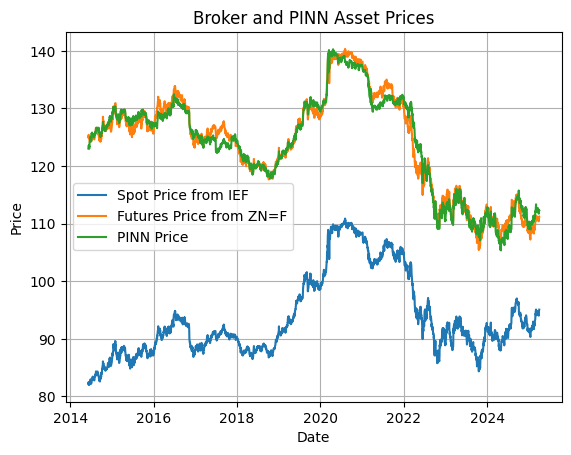

In [28]:
# Fixed Income - 10-Year T-Note Futures
ZN_data = test_PINN('IEF','ZN=F',showVis=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------
Final Test Physics Loss: 0.0043
Final Test MSE Loss: 0.0028
Final Test Total Loss: 0.0041


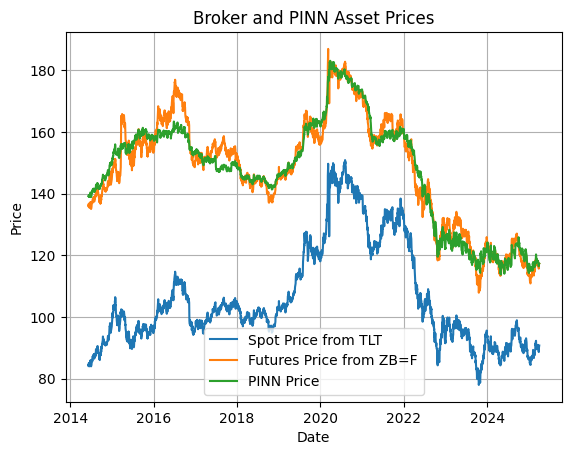

In [29]:
# Fixed Income - 30-Year T-Bond Futures
ZB_data = test_PINN('TLT','ZB=F',showVis=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------
Final Test Physics Loss: 0.0010
Final Test MSE Loss: 0.0007
Final Test Total Loss: 0.0010


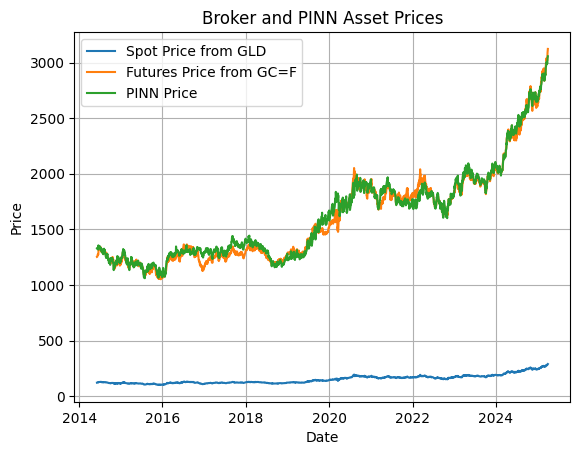

In [30]:
# Commodities - Gold
GC_data = test_PINN('GLD','GC=F',showVis=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------
Final Test Physics Loss: 0.0021
Final Test MSE Loss: 0.0007
Final Test Total Loss: 0.0013


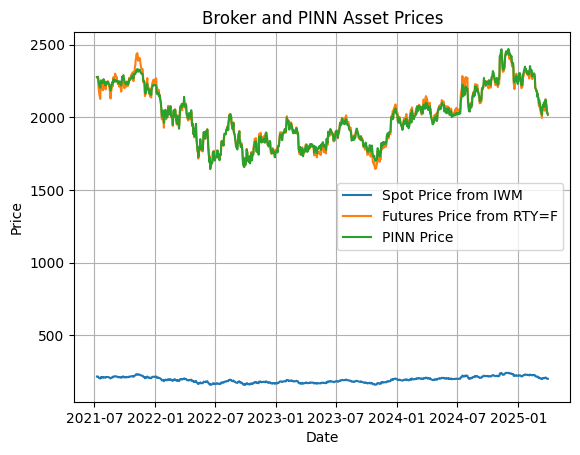

In [31]:
# Equities - Russell 2000
RTY_data = test_PINN('IWM','RTY=F',showVis=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------
Final Test Physics Loss: 0.0009
Final Test MSE Loss: 0.0004
Final Test Total Loss: 0.0007


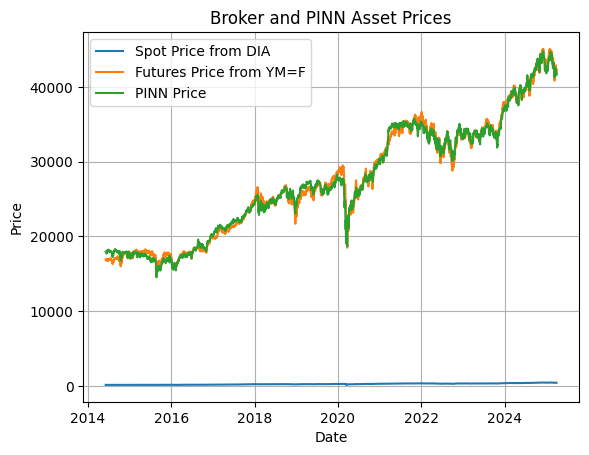

In [32]:
# Equities - Dow Jones
YM_data = test_PINN('DIA','YM=F',showVis=True)

### Exploring 30-Year Bond Futures to Identify Relationship Between Price Discrepancies and Future Price Drop

I want to test if there is a relationship between times where the PINN price is significantly lower than the broker price and the price of the future significantly drops

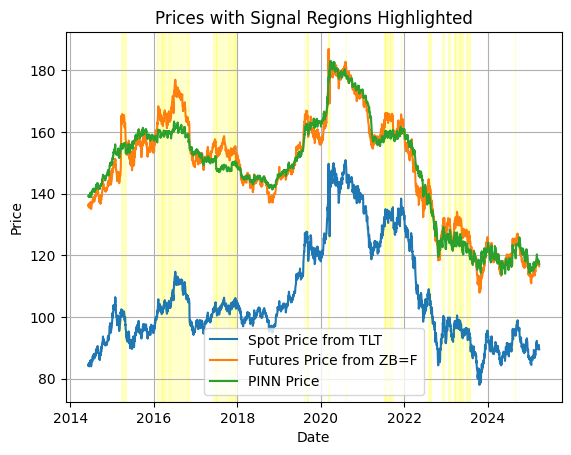


T‑test (return after signal vs no signal):
  t‑stat = -5.3876, p‑value = 0.00000010


In [33]:
# for 30-year t-bond futures
df = getDropSignalsDf(ZB_data,'TLT','ZB=F',sd=1,t=5)
visDropSignals('TLT','ZB=F',df)
analyzeCausation(df,'ZB=F')

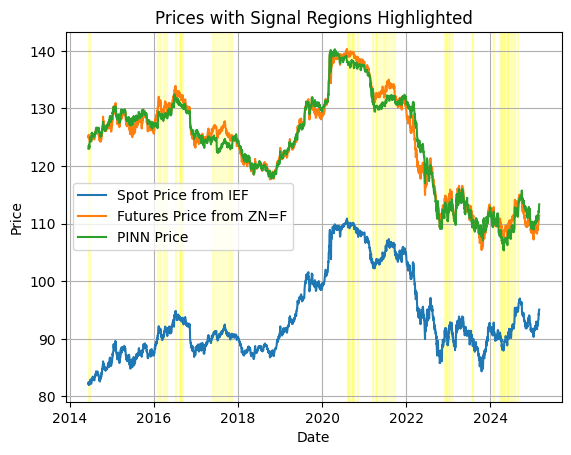


T‑test (return after signal vs no signal):
  t‑stat = -2.2413, p‑value = 0.02527252


In [34]:
# for 10-year t-note futures
df = getDropSignalsDf(ZN_data,'IEF','ZN=F',sd=1,t=20)
visDropSignals('IEF','ZN=F',df)
analyzeCausation(df,'ZN=F')